In [345]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import textwrap
from scipy.stats import entropy

In [346]:
# Load the data
df_pbs = pd.read_csv('../pbs_c/cmake-build-debug/pbsBlocks.csv')
df_cmp = pd.read_csv('../pbs_c/cmake-build-debug/comparison.csv')

In [347]:
df_pbs.describe()

,Block Number,Proposer ID,Builder ID,Winning Bid Value,Winning Block Value,Reward,Builder ID 1 Bid,Builder ID 2 Bid,Builder ID 3 Bid,Builder ID 4 Bid,...,Builder ID 1 Block Value,Builder ID 2 Block Value,Builder ID 3 Block Value,Builder ID 4 Block Value,Builder ID 5 Block Value,Builder ID 10 Block Value,Builder ID 30 Block Value,Builder ID 50 Block Value,Builder ID 70 Block Value,Builder ID 90 Block Value
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,26.142800,41.264200,462.171207,507.177099,227.580150,98.644313,43.866548,77.871969,140.152291,...,364.966747,281.579501,336.197392,408.798347,313.559818,341.161664,519.793976,272.75774,446.350237,477.930656
std,1443.520003,30.614491,32.988835,116.425051,127.931302,212.775662,173.146951,118.738168,156.374320,197.760997,...,127.466582,116.885432,124.907707,131.165907,122.427109,119.956131,120.622694,116.72738,121.043228,119.959599
min,1.000000,1.000000,1.000000,11.591800,11.591800,0.051703,0.000000,0.000000,0.000000,0.000000,...,39.596700,12.338400,11.591800,15.498400,5.167970,10.827400,67.496300,5.25868,20.419600,60.692200
25%,1250.750000,3.000000,5.000000,398.966250,439.234000,47.311575,0.000000,0.000000,0.000000,0.000000,...,277.427500,195.552500,244.249250,316.677750,224.427250,257.102000,440.175750,188.68225,362.897500,395.687500
50%,2500.500000,10.000000,30.000000,476.566000,525.992500,132.340000,0.000000,0.000000,0.000000,0.000000,...,356.496000,273.368500,327.832500,404.117500,303.732000,339.877000,521.921500,267.12200,446.005500,477.815500
75%,3750.250000,50.000000,70.000000,537.442750,591.178750,418.041000,198.747250,0.000000,0.000000,336.952500,...,448.247750,355.141750,417.886500,496.060500,391.352750,422.581000,602.969000,347.70825,530.456500,560.496500
max,5000.000000,90.000000,90.000000,941.863000,941.863000,941.863000,671.305000,579.007000,658.089000,667.445000,...,836.605000,737.825000,800.030000,829.871000,806.210000,820.704000,931.125000,819.20100,941.863000,896.200000


In [348]:
def get_builder_type(id):
    if 1 <= id <= 9:
        return 'Normal Proposer Builder'
    elif 10 <= id <= 999:
        return 'MEV Proposer Builder'
    else:
        return 'Unknown Builder'

def adjust_builder_id(id):
    if(get_builder_type(id) == 'MEV Proposer Builder'):
        return int(int(id) / 20 + 1)
    else:
        return id

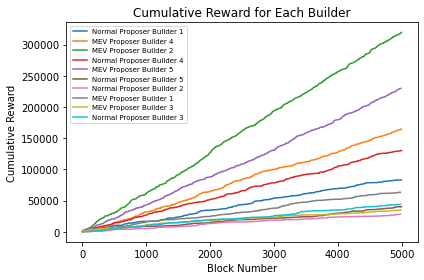

In [349]:
builder_ids = df_pbs['Builder ID'].unique()
fig, axs = plt.subplots()
for builder_id in builder_ids:
    builder_df_pbs = df_pbs[df_pbs['Builder ID'] == builder_id]
    cumulative_rewards = np.cumsum([reward for reward, id in zip(df_pbs['Reward'], df_pbs['Builder ID']) if id == builder_id])
    axs.plot(builder_df_pbs['Block Number'].values, cumulative_rewards, label=f'{get_builder_type(builder_id)} {adjust_builder_id(builder_id)}')

axs.set_title('Cumulative Reward for Each Builder')
axs.set_xlabel('Block Number')
axs.set_ylabel('Cumulative Reward')
axs.legend(loc='best',prop={'size': 7})
plt.tight_layout()
plt.show()

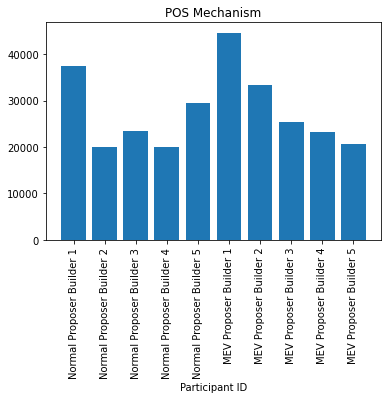

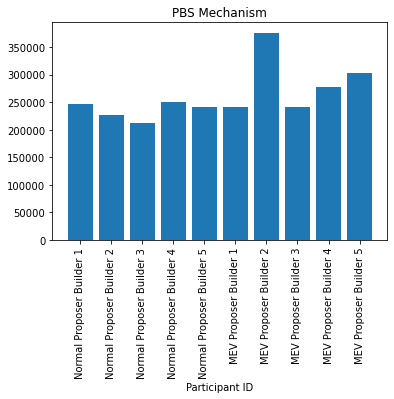

In [350]:
total_rewards_pos = []
total_rewards_pbs = []
builder_ids = np.sort(df_pbs['Builder ID'].unique())

for builder_id in builder_ids:
    cumulative_rewards_pbs = ([reward for reward, id, b_id in zip(df_pbs['Reward'], df_pbs['Builder ID'],df_pbs['Proposer ID']) if id == builder_id & id != b_id]+
                             [bid for bid, id in zip(df_pbs['Winning Bid Value'], df_pbs['Proposer ID']) if id == builder_id])
    total_rewards_pbs.append(sum(cumulative_rewards_pbs))

    cumulative_rewards_pos = [reward for reward, id in zip(df_cmp['POS Block Value'], df_cmp['POS Builder ID']) if id == builder_id]
    total_rewards_pos.append(sum(cumulative_rewards_pos))


builder_labels = [f'{get_builder_type(builder_id)} {adjust_builder_id(builder_id)}' for builder_id in builder_ids]
plt.bar(builder_labels, total_rewards_pos)
plt.title('POS Mechanism')
plt.xlabel('Participant ID')
plt.xticks(rotation=90) 
plt.show()

plt.bar(builder_labels, total_rewards_pbs)
plt.title('PBS Mechanism')
plt.xlabel('Participant ID')
plt.xticks(rotation=90) 
plt.show()



In [351]:
def gini(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

In [352]:
#this is for homogenous builders, 5 extra nodes, 10000 blocks. 
gini_pbs = gini(np.array(total_rewards_pbs))
gini_pos = gini(np.array(total_rewards_pos))

print(f'Gini coefficient for PBS rewards: {gini_pbs}')
print(f'Gini coefficient for POS rewards: {gini_pos}')

Gini coefficient for PBS rewards: 0.08465004721724886
Gini coefficient for POS rewards: 0.154026755831973


In [353]:
# Herfindahl-Hirschman Index (HHI) 
def hhi(x):
    """Compute Herfindahl-Hirschman Index of array of values"""
    return (x**2).sum() / (x.sum())**2

hhi_pos = hhi(np.array(total_rewards_pos))
hhi_pbs = hhi(np.array(total_rewards_pbs))

print(f"HHI for PBS: {hhi_pbs}")
print(f"HHI for POS: {hhi_pos}")

HHI for PBS: 0.10294877914393673
HHI for POS: 0.10813496071221117


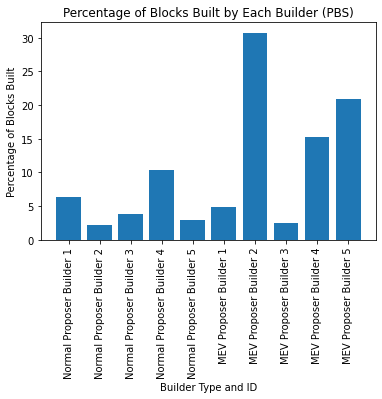

In [354]:
block_counts = [len(df_pbs[df_pbs['Builder ID'] == builder_id]) for builder_id in builder_ids]
block_percentages = [count / len(df_pbs) * 100 for count in block_counts]

plt.bar(builder_labels, block_percentages)
plt.title('Percentage of Blocks Built by Each Builder (PBS)')
plt.xlabel('Builder Type and ID')
plt.ylabel('Percentage of Blocks Built')
# Rotate the x-axis labels
plt.xticks(rotation=90) 
plt.show()


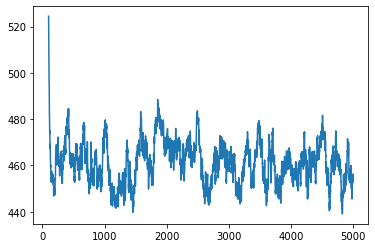

In [355]:
df_pbs['Winning Bid Value'].rolling(window=100).mean().plot()
plt.show()

<AxesSubplot:>

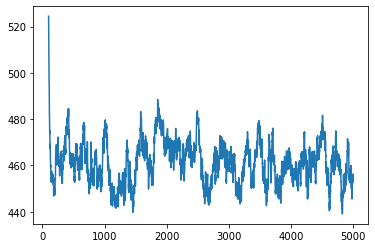

In [356]:
df_pbs['Winning Bid Value'].rolling(window=100).mean().plot()